In [1]:
!pip install geemap

In [123]:
import hydrofunctions as hf
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import folium
import geemap.foliumap as geemap
import ee
import matplotlib.dates as mdates
import hydrofns
import calendar
import pandas as pd

%matplotlib inline

In [3]:
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWjFVEGVwL7p-CiiJQGuC3lN7-f-10sTY9P0mA15lB03x2XGRra80Z4

Successfully saved authorization token.


In [99]:
# site number for NWIS gage (Pine Bluff AR Site)
pineBluff = ['07263650']

# Coordinates for the bounds of a rectangle at Pine Bluff AR
pineBluff_xMin = -92.4
pineBluff_yMin = 34
pineBluff_xMax = -91.7
pineBluff_yMax = 34.4

# Pine Bluff geometry
pineBluff_rectangleGeoJSON = ee.Geometry.Rectangle(
    [
        [pineBluff_xMin, pineBluff_yMin],
        [pineBluff_xMax, pineBluff_yMax]   # max x and y
    ])

pineBluff_bnds = ee.FeatureCollection([
    ee.Feature(
        pineBluff_rectangleGeoJSON,
        {'name': 'Pine Bluff, AR', 'fill': 1}),])

# Palettes for Visualization
trueColor_palette = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
waterPalette = ['red', 'yellow', 'green', 'blue']

# Import the Sentinel 2 collection as sentinel 2
sentinel2 = ee.ImageCollection(
    'COPERNICUS/S2_SR').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))

In [145]:
def get_water_pixel_count(bounds, start, end):
    """
    Add docstring here.
    """
    ndwi_threshold = 0
    sentinel_image = sentinel2.filterBounds(
        bounds).filterDate(start, end).mosaic().clip(bounds)
    ndwi_image = sentinel_image.normalizedDifference(['B3', 'B8'])
    water_pixel_image = ndwi_image.gt(ndwi_threshold).selfMask()

    pixel_count_dict = water_pixel_image.reduceRegion(**{
        'reducer': ee.Reducer.count(),
        'geometry': bounds.geometry(),
        'scale': 10,
        'maxPixels': 1e9})
    pixel_count = pixel_count_dict.getInfo()
    
    return pixel_count

# Need to figure out how to iterate through months with function
pb_jan = get_water_pixel_count(pineBluff_bnds, '2019-01-01', '2019-01-30')
pb_feb = get_water_pixel_count(pineBluff_bnds, '2019-02-01', '2019-02-28')
pb_mar = get_water_pixel_count(pineBluff_bnds, '2019-03-01', '2019-03-30')
pb_apr = get_water_pixel_count(pineBluff_bnds, '2019-04-01', '2019-04-30')
pb_may = get_water_pixel_count(pineBluff_bnds, '2019-05-01', '2019-05-30')
pb_jun = get_water_pixel_count(pineBluff_bnds, '2019-06-01', '2019-06-30')
pb_jul = get_water_pixel_count(pineBluff_bnds, '2019-07-01', '2019-07-30')
pb_aug = get_water_pixel_count(pineBluff_bnds, '2019-08-01', '2019-08-30')
pb_sep = get_water_pixel_count(pineBluff_bnds, '2019-09-01', '2019-09-30')
pb_oct = get_water_pixel_count(pineBluff_bnds, '2019-10-01', '2019-10-30')
pb_nov = get_water_pixel_count(pineBluff_bnds, '2019-11-01', '2019-11-30')
pb_dec = get_water_pixel_count(pineBluff_bnds, '2019-12-01', '2019-12-30')

list = [pb_jan, pb_feb, pb_mar, pb_apr, pb_may, pb_jun, pb_jul, pb_aug, pb_sep, pb_oct, pb_nov, pb_dec]

print(list)


[{'nd': 1129526}, {'nd': 913360}, {'nd': 782970}, {'nd': 697519}, {'nd': 565695}, {'nd': 778707}, {'nd': 293770}, {'nd': 608307}, {'nd': 617674}, {'nd': 518732}, {'nd': 690280}, {'nd': 236178}]


In [138]:
df = pd.DataFrame(list, columns = ['nd'])

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07263650&parameterCd=00065&startDT=2019-01-01&endDT=2019-12-30


[Text(0.5, 0, 'Date (Month-Day)'),
 Text(0, 0.5, 'Daily Mean Gage Height \n (ft)')]

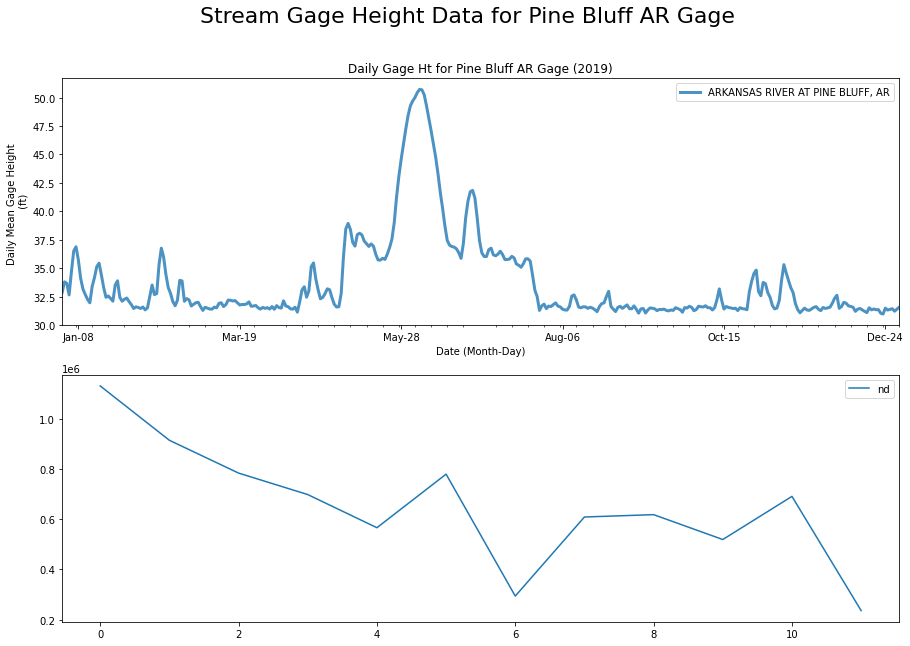

In [144]:
start='2019-01-01'
end='2019-12-30'
pineBluff_site_df = hydrofns.create_df_gageht(
    pineBluff, start, end)
#pineBluff_site_df

# Define plot space, overall size and title
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

fig.suptitle(
    "Stream Gage Height Data for Pine Bluff AR Gage", fontsize=22)

# Loop for plotting Subplot 1
pineBluff_site_df.plot(y='gage ht',
                       title="Daily Gage Ht for Pine Bluff AR Gage (2019)",
                       label='ARKANSAS RIVER AT PINE BLUFF, AR',
                       linewidth=3.0,
                       ax=ax1,
                       alpha=.8)
df.plot(y='nd', 
       ax=ax2)

# Define the date format for Subplot 1, set axis labels
date_form = DateFormatter("%b-%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
ax1.set(xlabel="Date (Month-Day)",
        ylabel="Daily Mean Gage Height \n (ft)")

#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 11})

In [ ]:
# See rimorphis_water_pixel_count_testing file for why Jan pixel counts are so high. 
# Some months have high water pixel counts outside of river (agricultural watering, etc...), which messes 
# with our accuracy. Need to redefine bounds so we only count water pixels near river and river banks, not 
# on agricultural fields. 

# Also need to confirm that using compilation image for each month, counting water pixels for each monthly compilation
# image, and plotting against monthly max values is acceptable method. 

# Using above method ensures we get a clear enough image to count water pixels on. Otherwise, cloud cover for less 
# than one month date range blocks accurate water pixel count. 

# Need to figure out how to iterate through months. (datetime package?)